# Posterior Distributions
Andrew Esch, Evan Lee, and Collin Stratton

CST-425

Dr. Isac Artzi

2 April, 2022

# Introduction
The purpose of this assignment is to explore Markov Chain Monte Carlo (MCMC) by predicting the likelihood of people visiting a given attraction. This project will analyze and visualize the posterior distributions of the locations visited by tourists.

## Markov Chain Monte Carlo
Markov Chain Monte Carlo (MCMC) is a technique for systematic random sampling from high-dimensional probability distributions. The Markov Chain draws samples from the distribution, and then uses the samples to update the distribution. The process is repeated until a desired number of samples is obtained, even with a large number of random variables. It's not as effective for high-dimensional probabilistic methods, but it provides an alternative approach to random sampling. Metropolis-Hastings algorithm, the algorithm used in the MCMC for this project, is a common approach to Markov Chain Monte Carlo.

# Setup
The data was taken from halo and will be used to show off the markov chain monte carlo algorithms.

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MarkovFunctions import *

In [3]:
# read in data
df = pd.read_csv("./syntheticdata.csv", header=None)
# row and column headers list
headers = ["Museum", "Concert", "Sports Event", "Restaurant", "Hike"]

print(df)

   0  1  2  3  4
0  1  3  5  3  3
1  7  1  4  6  3
2  8  2  2  5  4
3  5  4  5  3  1
4  2  4  1  5  1


In [4]:
# Convert into a probabilistic matrix, and then convert the probabilistic matrix into a transition matrix
transitionMatrix = df.div(df.sum(axis=1), axis=0)
transitionMatrix = transitionMatrix.to_numpy()

print(transitionMatrix)

[[0.06666667 0.2        0.33333333 0.2        0.2       ]
 [0.33333333 0.04761905 0.19047619 0.28571429 0.14285714]
 [0.38095238 0.0952381  0.0952381  0.23809524 0.19047619]
 [0.27777778 0.22222222 0.27777778 0.16666667 0.05555556]
 [0.15384615 0.30769231 0.07692308 0.38461538 0.07692308]]


# Markov Chain
## Generate Steady State Distribution Graphs from the Transition Matrix using Markov Chains

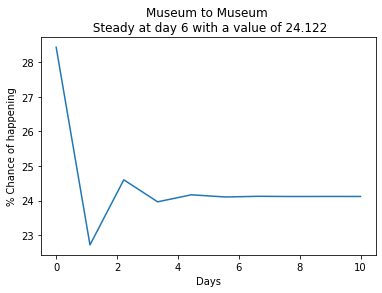

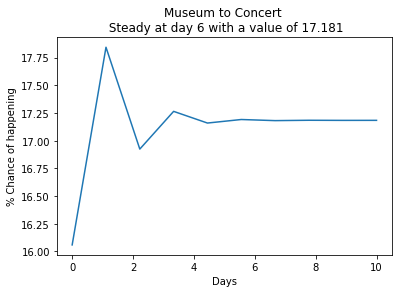

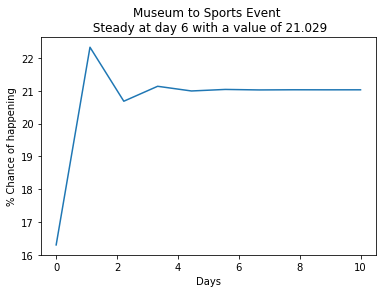

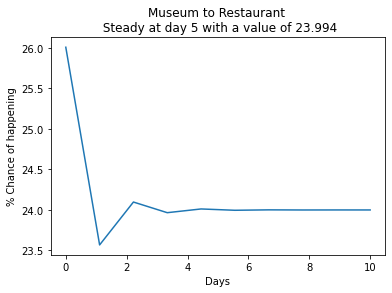

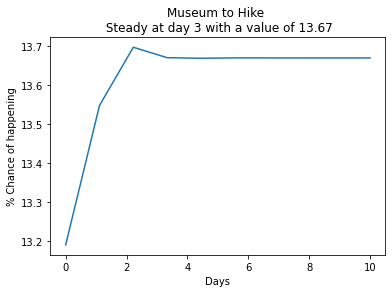

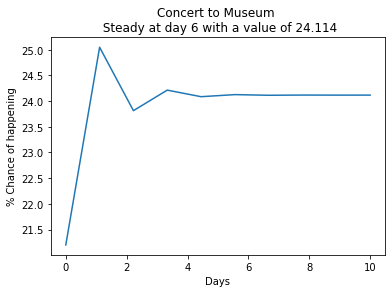

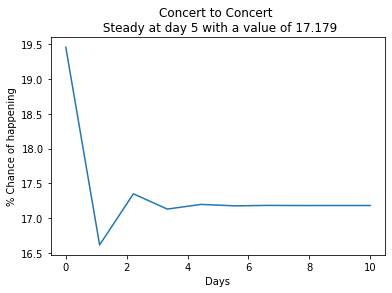

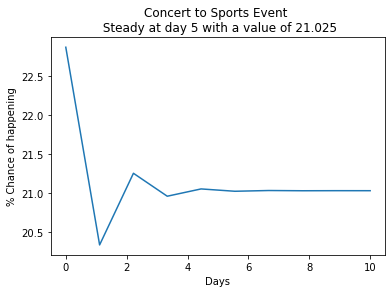

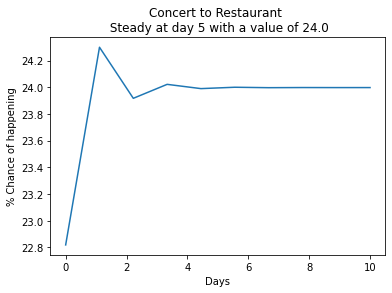

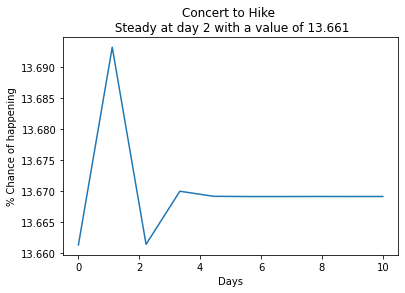

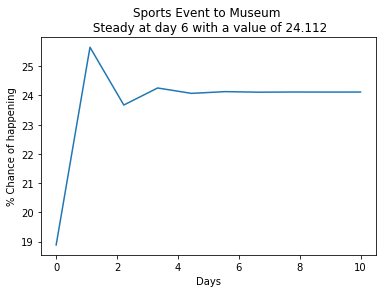

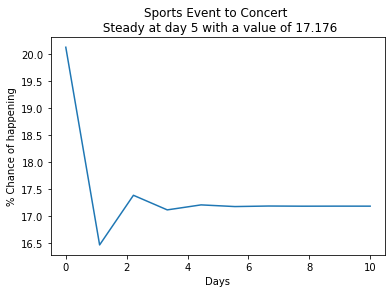

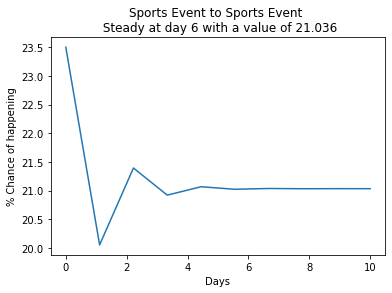

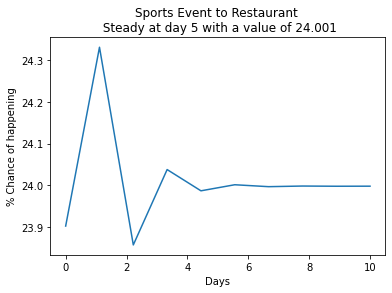

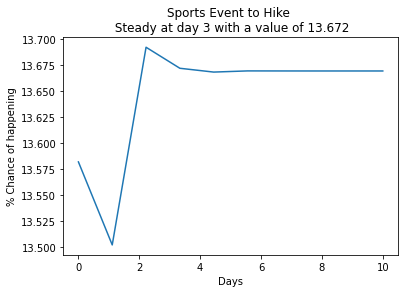

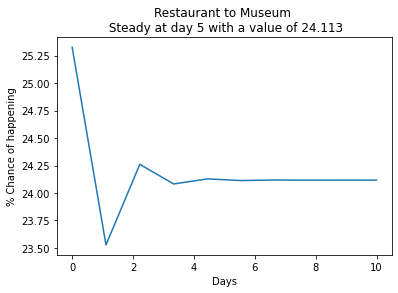

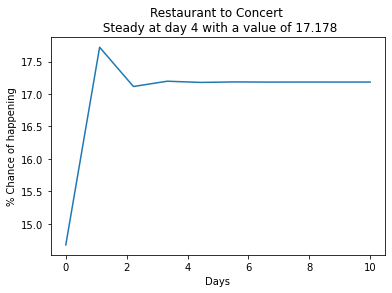

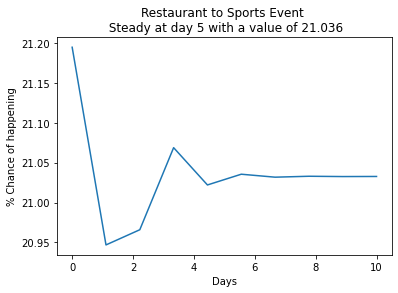

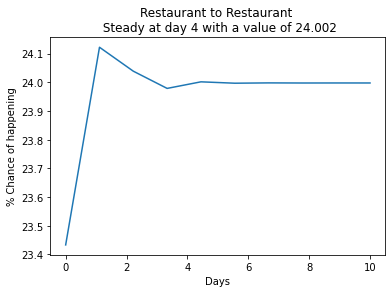

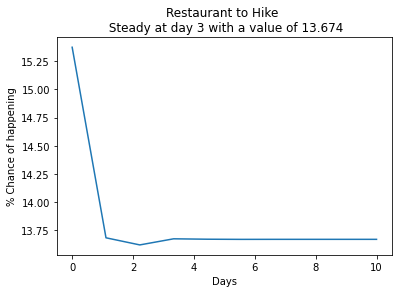

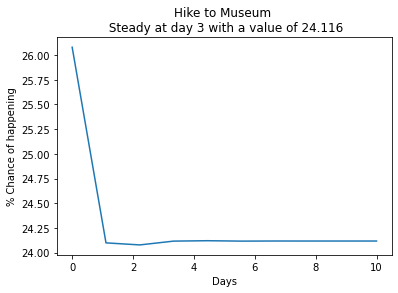

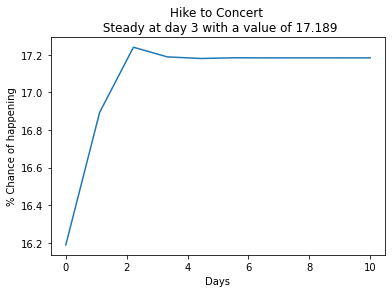

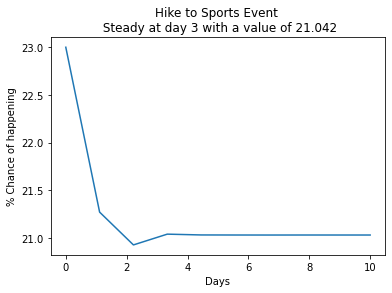

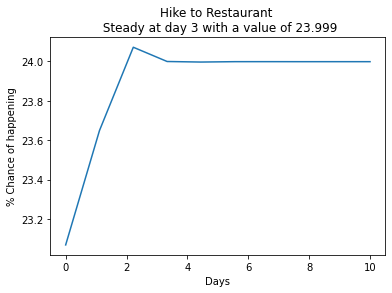

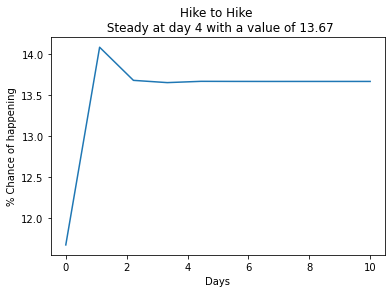

In [5]:
# Generate graphs from transition matrix to illustrate the Markov Chain
for i in range(transitionMatrix.shape[0]):
    for j in range(transitionMatrix.shape[1]):
        markovPlot(transitionMatrix, i, j, 11)

## Finding Probabilities
### Find the likelihood that a tourist would attend a concert, then go on a hike, then eat at a restaurant

In [6]:
# multiply the transition probability of concert to hike by hike to restaurant
concertHikeRestaurant = transitionMatrix[1][4] * transitionMatrix[4][3]
print("Percent odds of Concert to Hike to Restaurant = ", concertHikeRestaurant * 100)

Percent odds of Concert to Hike to Restaurant =  5.4945054945054945


### Find the likelihood of visiting any of the locations as the fifth step

In [7]:
# find the probabilities of the transition matrix on the 5th step
transDot = transitionMatrix
for i in range(4):  # Four transitions, so run 4 times
    transDot = np.dot(transDot, transitionMatrix)

# starting probability vector
spv = np.array([.2, .2, .2, .2, .2])

# sum the columns of the fifth step
sum_trans = transDot.sum(axis=0)

# multiply the starting probability vector by the sum of the columns
spv_tran = sum_trans * spv

# print the likelihood of visiting any of the locations as the fifth step
print("\nPercent odds of visiting the Museum 5th = ", spv_tran[0] * 100)
print("Percent odds of visiting the Concert 5th = ", spv_tran[1] * 100)
print("Percent odds of visiting the Sports Event 5th = ", spv_tran[2] * 100)
print("Percent odds of visiting the Restaurant 5th = ", spv_tran[3] * 100)
print("Percent odds of visiting the Hike 5th = ", spv_tran[4] * 100)


Percent odds of visiting the Museum 5th =  24.126087183341497
Percent odds of visiting the Concert 5th =  17.179216143611463
Percent odds of visiting the Sports Event 5th =  21.02655442956296
Percent odds of visiting the Restaurant 5th =  24.00018403603868
Percent odds of visiting the Hike 5th =  13.667958207445393


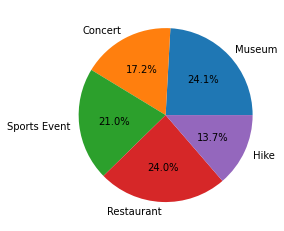

In [8]:
plt.pie(spv_tran, labels=headers, autopct='%1.1f%%')
plt.show()

## Metro-Hastings MCMC
Using the resources provided in class, as well as a myriad of online resources, we tried to implement the Metro Hastings MCMC. However, we ran into various issues with the implementation approaches we used, such as tools being caught in an infinite loop (known issue with the library), errors with versions of tools not being compatible, and various other issues that stalled the development of the Metro Hastings MCM in our code. The basic overview of how the Metro Hastings MCMC should have been implemented is as follows:
- Start with a random sample
- Determine the probability density associated with the sample
- Propose a new arbitrary sample and determine its probability density
- Compare densities to quantify the desire to move
- Generate a random number, compare with desire to move, and decide to move or stay
- Repeat

Below is our attempted implementation of this approach.

<ipython-input-9-11dd6d333592>:23: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(num_samples, step=step, start=start, random_seed=456)  # Perform sampling
/Users/collinstratton/Google Drive/School/GCU/Fall 2021 - Spring 2022/CST-425/CST-425/venv/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [Theta]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.


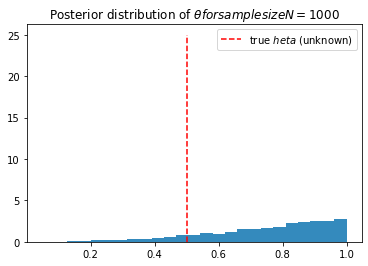

In [9]:
import pymc3 as pm

# Create a random training dataset
def randomDataset(n):
    choicesList = [1.0, 2.0, 3.0, 4.0, 5.0]
    return np.random.choice(choicesList, size=n, replace=True, p=spv_tran)


training = np.array(randomDataset(1000))  # Create a random dataset with 1000 observations

# Create the model with initial conditions
with pm.Model() as model:
    # Define the prior parameters
    theta = pm.Beta("Theta", alpha=3, beta=1)  # Define a basic beta distribution for the prior distribution
    observed = pm.Normal("Observed", mu=3, sigma=1, observed=training)  # Define likelihood using a normal Gaussian distribution with observed data

# Perform Metropolis-Hastings sampling
num_samples = 10000  # Set the number of total samples to take

with model:
    start = pm.find_MAP()  # Find the MAP of the model
    step = pm.Metropolis()  # Use sampling with Metropolis-Hastings steps
    trace = pm.sample(num_samples, step=step, start=start, random_seed=456)  # Perform sampling

# Plot the Metropolis-Hastings results
p_true = 0.5
# figsize(12.5, 4)
plt.title(r"Posterior distribution of $\theta for sample size N=1000$")
plt.vlines(p_true, 0, 25, linestyle='--', label="true $\theta$ (unknown)", color='red')
plt.hist(trace["Theta"], bins=25, histtype='stepfilled', density=True, color='#348ABD')
plt.legend()
plt.show()

# Conclusion
Monte Carlo Markov Chains are a powerful tool for modeling and analyzing data. In this notebook, we attempted to implement MCMC's in various ways and tried implementing the Metro Hastings MCMC. However, we ran into various issues with the implementation approaches we used, such as tools being caught in an infinite loop (known issue with the library), errors with versions of tools not being compatible, and various other issues that stalled the development of the Metro Hastings MCM in our code. Overall, MCMC's proved useful in many situations, and can help shape the interpretation of data.

# Resources
https://people.duke.edu/~ccc14/sta-663/MCMC.html

https://machinelearningmastery.com/markov-chain-monte-carlo-for-probability/

https://sdsawtelle.github.io/blog/output/mcmc-in-python-with-pymc.html

https://towardsdatascience.com/bayesian-statistics-metropolis-hastings-from-scratch-in-python-c3b10cc4382d